## Results walkthrough

This notebook contains the code used to produce the pilot results
reported as part of a submission to fulfill unit requirements of
FIT3144 - Advanced Computer Science Research Project.

Marcel Masque Salgado, October 2021.


### First, we load the data for bidirectionally connected neurons the Steinmetz dataset

 - We load only the data for a particular recording: Probe 1 (0
   indexed) from Cori_2016-12-14.
 - Bidirectionality was inferred using GLMCC code from Kobayashi et
   al. 2019. Computational costs mean that it is unfeasible to
   reproduce this analysis on a notebook.

1. The file find_connections.py was used to load steinmetz data into
   the format required by the GLMCC code.
2. Code for GLMCC, used on the prepared files, can be found in the
   GLMCC directory.

#### Load the sp ike data

(371,)


/tmp/ipykernel_54449/2980687135.py:20: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  good_neurons = np.array(individual_times)[good_indices].tolist()
/tmp/ipykernel_54449/2980687135.py:25: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  good_neurons_probe1 = np.array(individual_times)[good_indices_probe1]


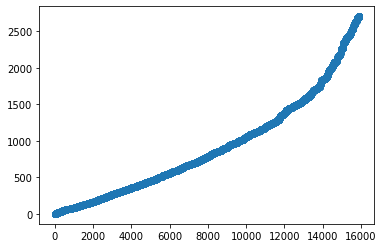

In [13]:
import numpy as np
import matplotlib.pyplot as plt

times = np.squeeze(np.load("Cori_2016-12-14/spikes.times.npy"))
clusters = np.squeeze(np.load("Cori_2016-12-14/spikes.clusters.npy"))
probe = np.squeeze(np.load("Cori_2016-12-14/clusters.probes.npy"))

minindex = min(clusters)
maxindex = max(clusters)

# split data into individual neuron arrays
individual_times = []
for i in range(minindex, maxindex+1):
    indices = np.where(clusters==i)[0]
    individual_times.append(times[indices].astype(float))

# get only the good neurons
annotations = np.squeeze(np.load("Cori_2016-12-14/clusters._phy_annotation.npy"))
good_indices = np.where(annotations >= 2)
good_neurons = np.array(individual_times)[good_indices].tolist()

probe1_indices = np.nonzero(probe)[0]
good_indices_probe1 = np.intersect1d(good_indices,probe1_indices)
print(good_indices_probe1.shape)
good_neurons_probe1 = np.array(individual_times)[good_indices_probe1]

plt.scatter(np.arange(good_neurons_probe1[0].shape[0]),
            good_neurons_probe1[0])
plt.show()

In [4]:
## Save the data to files
from find_connections import SteinmetzLoader
SteinmetzLoader.save_to_files(good_neurons_probe1, "supercomputer/pawsey/data")

In [7]:
### OBTAIN BIDIRECTIONALLY CONNECTED NEURONS ###
probe1_371 = np.loadtxt("results/connectivity_Cori_2016-12-14_probe1/W_py_5400.csv", delimiter=",")

# probe1_371 is the 371-neuron functional (directed) connectivity matrix
# estimated by GLMCC, not spiking data
print(probe1_371.shape)

(371, 371)


### Next, obtain neuron tuples that GLMCC finds to be bidirectionally connected

 - Saves to a file: bidirectionally.txt

In [4]:
# get tuples of connected neurons
ai,bi = np.where(abs(probe1_371) != 0) # array([neuron0,  neuron0,  neuron1, ...]),
                                       # array([n0index0, n0index1, n1index0, ... ])

index_pairs = list(zip(ai,bi))         # [(n0, n0i0), (n0, n0i1), (n1, n1i0), ...]

with open("bidirectionally.txt", 'w') as f:
    bidirectionally = []
    for (r,t) in index_pairs:
        if (t,r) in index_pairs and (t,r) not in bidirectionally:
            bidirectionally.append((r,t))
            f.write(str(r) + " " + str(t) + "\n")

### Compute Phi for these neurons at varying temporal scales

 - This was done on the Pawsey supercomputer due to computational constraints
 - The file `temporal_emergence.py` provides classes and methods to
   binarise data, compute Transition Probability Matrices (TPMs) from
   data, coarse grain TPMs, and compute a TPM's phi using the PyPhi
   library's nonbinary branch.
 - These were then used to compute Phi at varying temporal scales

### Load the results

In [3]:
all_16_macro_micros_connected = np.load("results/all_16coarsegrains_macro_micros_random_fixed1.npy",
                                        allow_pickle=True)
all_16_macro_micros_disconnected = np.load("results/all_16coarsegrains_macro_micros_disconnected_fixed1.npy",
                                           allow_pickle=True)
print(all_16_macro_micros_connected.shape)
print(all_16_macro_micros_disconnected.shape)

(732, 3)
(736, 3)


### Get the maximums for each coarse graining

In [4]:
def get_max_macros_micros(dataset):
    max_micros_wnan = []
    max_macros_wnan = [[] for i in range(16)]

    for micros,macros,(i,j) in dataset:
        max_micros_wnan.append(np.nanmax(micros))
        max_macro = np.nanmax(macros, axis=(0,1))
        for m in range(len(max_macro)):
            max_macros_wnan[m].append(max_macro[m])

    max_micros = np.array(max_micros_wnan)
    #print([i for i, x in enumerate(~np.isnan(max_micros)) if x])
    max_micros = max_micros[~np.isnan(max_micros)]

    max_macros = [np.array(m_mac) for m_mac in max_macros_wnan]
    max_macros = [m_mac[~np.isnan(m_mac)] for m_mac in max_macros]
    return max_macros, max_micros
max_macros_connected, max_micros_connected = get_max_macros_micros(all_16_macro_micros_connected)
max_macros_disconnected, max_micros_disconnected = get_max_macros_micros(all_16_macro_micros_disconnected)

# max big Phi's (micro scale), 78 neuron pairs
print(str(type(max_micros_connected)) + str(len(max_micros_connected)))
print(max_micros_connected)
print (f"max Phi micros (all 78 pairs): {max(max_micros_connected)}")

# max big Phi's (macro scale), 16 possible mappings x 78 pairs each
print(str(type(max_macros_connected)) + str(len(max_macros_connected)))
print(str(type(max_macros_connected[15])) + str(len(max_macros_connected[15])))
print(max_macros_connected[15])
for max_macros_connected_mapping in max_macros_connected:
    print (f"max Phi macros (mapping): {max(max_macros_connected_mapping)}")


<class 'numpy.ndarray'>78
[0.02111644 0.00975062 0.01783756 0.00799437 0.01947038 0.02074969
 0.01509019 0.01341587 0.00963944 0.01424469 0.01309319 0.01632606
 0.01763375 0.01379988 0.01154094 0.01270169 0.02062644 0.01861369
 0.023187   0.01860156 0.01772456 0.01942681 0.01082281 0.0143585
 0.01558287 0.0163125  0.02306188 0.01182175 0.01917375 0.01484306
 0.01303669 0.02983488 0.01604025 0.01317744 0.00925144 0.02113087
 0.03065281 0.02188987 0.00868175 0.01595725 0.00988806 0.01876025
 0.0213685  0.01165475 0.01844481 0.01554894 0.02161987 0.03556569
 0.01616206 0.016784   0.01738112 0.01741419 0.01216163 0.02471856
 0.009152   0.04081075 0.01420319 0.01082625 0.01195169 0.0186145
 0.01948662 0.02128719 0.0107725  0.01136406 0.02114831 0.01166569
 0.01957663 0.0158605  0.01777938 0.01379069 0.03096925 0.03129837
 0.00929975 0.02573731 0.014001   0.02314819 0.012997   0.029114  ]
max Phi micros (all 78 pairs): 0.04081075000000001
<class 'list'>16
<class 'numpy.ndarray'>78
[0.0211164

/tmp/ipykernel_23997/1834691624.py:6: RuntimeWarning: All-NaN slice encountered
  max_micros_wnan.append(np.nanmax(micros))
/tmp/ipykernel_23997/1834691624.py:7: RuntimeWarning: All-NaN slice encountered
  max_macro = np.nanmax(macros, axis=(0,1))


### Plot the macro Phi values for each coarse graining

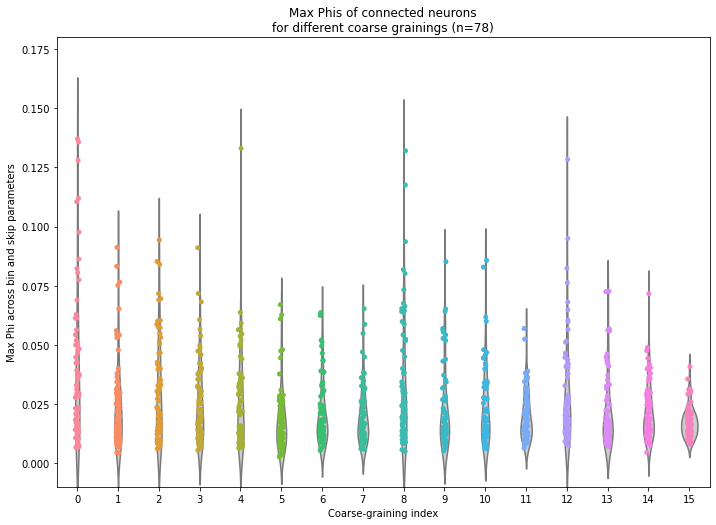

<Figure size 432x288 with 0 Axes>

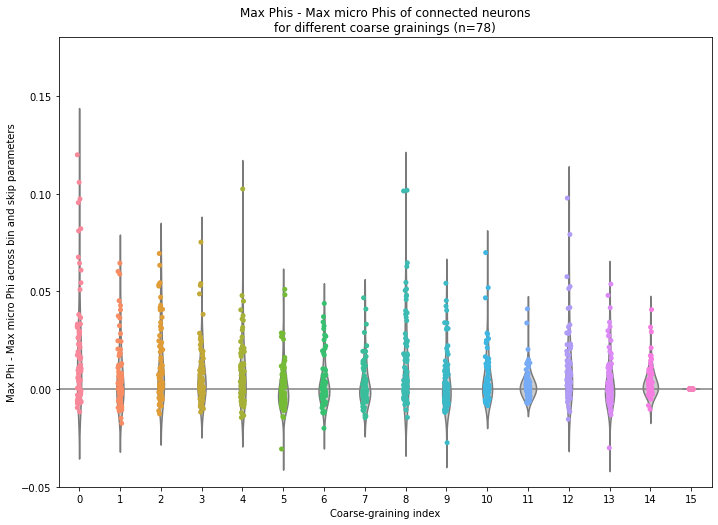

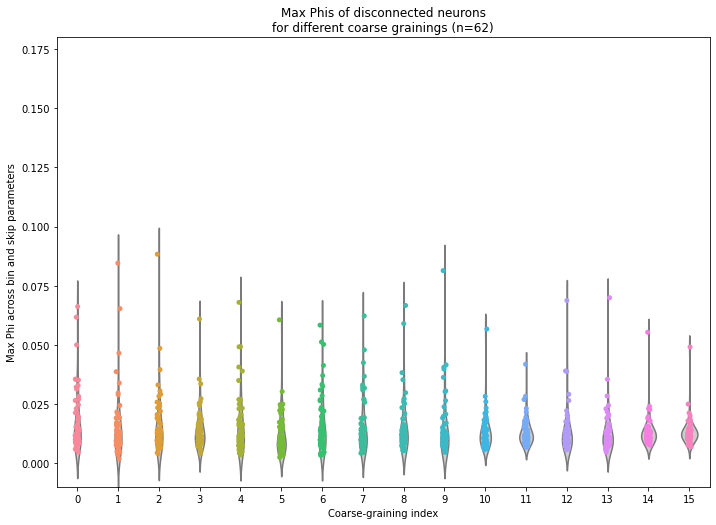

<Figure size 432x288 with 0 Axes>

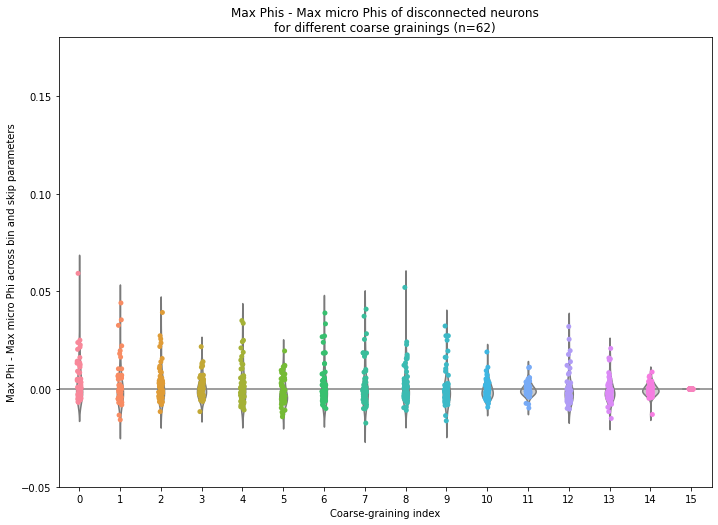

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def plot_max_macros_across_coarsegrainings(max_macros, max_micros, connected):
    df = pd.DataFrame(np.transpose(np.array(max_macros)))
    a4_dims = (11.7, 8.27)
    fig, ax = plt.subplots(figsize=a4_dims)

    ax = sns.violinplot(ax=ax,data=df, orient='v', color=".8", inner=None, width=0.4)
    ax = sns.stripplot(ax=ax,data=df, orient='v',jitter=0.05)
    plt.xlabel("Coarse-graining index")
    plt.ylabel("Max Phi across bin and skip parameters")
    plt.title(f"Max Phis of {connected} neurons\nfor different coarse grainings (n={len(max_macros[0])})")
    plt.ylim([-0.01, 0.18])
    plt.figure()
    fig, ax = plt.subplots(figsize=a4_dims)
    df2 = pd.DataFrame(np.transpose([max_macro - max_micros for max_macro in np.array(max_macros)]))
    ax = sns.violinplot(ax=ax,data=df2, orient='v', color=".8", inner=None, width=0.4)
    ax = sns.stripplot(ax=ax,data=df2, orient='v',jitter=0.05)
    plt.axhline(y=0, color='gray', linestyle='-')
    plt.xlabel("Coarse-graining index")
    plt.ylabel("Max Phi - Max micro Phi across bin and skip parameters")
    plt.title(f"Max Phis - Max micro Phis of {connected} neurons\nfor different coarse grainings (n={len(max_macros[0])})")
    plt.ylim([-0.05, 0.18])

plot_max_macros_across_coarsegrainings(max_macros_connected, max_micros_connected, "connected")
plot_max_macros_across_coarsegrainings(max_macros_disconnected, max_micros_disconnected, "disconnected")

### Get maximum across all macro coarse grainings for every neuron

In [6]:
#max of all macros
def get_sup_macros(max_macros):
    sup_macros = []
    for i in range(len(max_macros[0])):
        # len - 1 to avoid the last coarse graining, which is the micro
        sup_macros.append(max([max_macros[j][i] for j in range(len(max_macros)-1)]))
    return sup_macros

sup_macros_connected = get_sup_macros(max_macros_connected)
sup_macros_disconnected = get_sup_macros(max_macros_disconnected)

### Get mean across all macro coarse grainings for every neuron

In [7]:
# mean of all macros
def get_mean_macros(max_macros):
    mean_macros = []
    for i in range(len(max_macros[0])):
        mean_macros.append(sum([max_macros[j][i] for j in range(len(max_macros)-1)]) / (len(max_macros)-1))
    return mean_macros
mean_macros_connected = get_mean_macros(max_macros_connected)
mean_macros_disconnected = get_mean_macros(max_macros_disconnected)

### Plot combined plots of the datasets

Text(0.5, 1.0, 'Phis for connected/disconnected pairs')

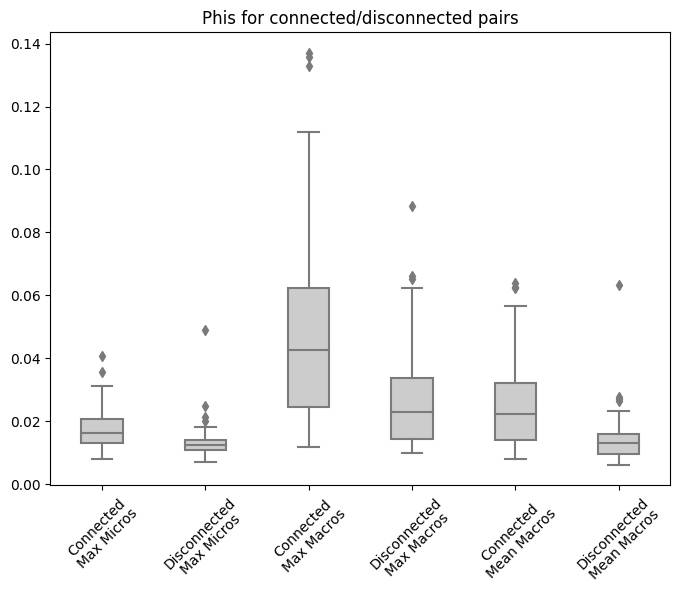

In [8]:
# combined plots
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(8,6), dpi=100)
ax = sns.boxplot(data=[max_micros_connected, max_micros_disconnected, sup_macros_connected, sup_macros_disconnected, mean_macros_connected, mean_macros_disconnected], orient='v', color=".8", width=0.4)
#ax = sns.stripplot(data=[connected_micros, disconnected_micros, connected_macros, disconnected_macros], orient='v',jitter=0.05)
#plt.ylabel("Phi")
plt.xticks(range(6), ["Connected\nMax Micros", "Disconnected\nMax Micros","Connected\nMax Macros", "Disconnected\nMax Macros", "Connected\nMean Macros", "Disconnected\nMean Macros"], rotation=45)
plt.title("Phis for connected/disconnected pairs")

#plt.ylim([-0.03,0.17])
# colors = [0.7, 0.7, 1,1,1,1]
# for i in range(0,6):
#     mybox = ax.artists[i]
#     if i in [1,3,5]:
#         mybox.set_hatch("////")
#     mybox.set_facecolor(str(colors[i]))

## Analysis of individual neuron pair 288, 289

 - First we identify the pair with highest phi value and show all its phi values
 - Then we show its micro TPM and the macro TPM that maximises Phi

# of skips: 5
# of binsizes: 9
shape of all_16_macro_micros_connected: (732, 3)
shape of all_16_macro_micros_connected[0]: (3,)
shape of all_16_macro_micros_connected[[0],[0]]: (1,)
shape of all_16_macro_micros_connected[[0],[0]][0]: (9, 5)
[[nan nan nan nan nan]
 [nan nan nan nan nan]
 [nan nan nan nan nan]
 [nan nan nan nan nan]
 [nan nan nan nan nan]
 [nan nan nan nan nan]
 [nan nan nan nan nan]
 [nan nan nan nan nan]
 [nan nan nan nan nan]]
shape of all_16_macro_micros_connected[[0],[1]][0]: (9, 5, 16)
[[[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan]
  [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan]
  [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan]
  [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan]
  [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan]]

 [[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan]
  [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan]
  [nan nan

/tmp/ipykernel_23997/2206832146.py:29: RuntimeWarning: All-NaN slice encountered
  max_micros_wnan.append(np.nanmax(micros))
/tmp/ipykernel_23997/2206832146.py:30: RuntimeWarning: All-NaN slice encountered
  max_macro = np.nanmax(macros, axis=(0,1))


(288, 289)


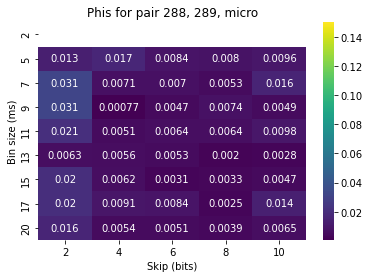

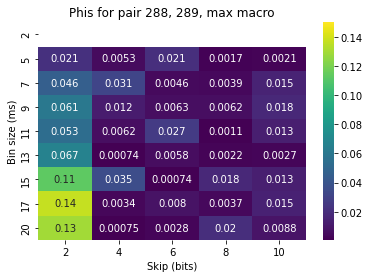

In [9]:
NUM_BITS = 2
skips = list(range(2,11,2))
print (f"# of skips: {len(skips)}")

max_binsize = 0.02  # 20 ms bins
min_binsize = 0.0029 # skip 1ms bins  -   never work and are very slow to compute
num_binsizes = 9
binsizes = np.linspace(min_binsize, max_binsize, num_binsizes)
print (f"# of binsizes: {len(binsizes)}")
binsize_strs = [str(int(b*1000)) for b in binsizes]
occurrences = range(100, 1100, 100)
NUM_REPETITIONS = 100

### recompute max phis in a slightly different array format ###
max_micros_wnan = []
max_macros_wnan = [[] for i in range(16)]

print (f"shape of all_16_macro_micros_connected: {all_16_macro_micros_connected.shape}")
print (f"shape of all_16_macro_micros_connected[0]: {all_16_macro_micros_connected[0].shape}")
print (f"shape of all_16_macro_micros_connected[[0],[0]]: {all_16_macro_micros_connected[[0],[0]].shape}")
print (f"shape of all_16_macro_micros_connected[[0],[0]][0]: {all_16_macro_micros_connected[[0],[0]][0].shape}")
print(all_16_macro_micros_connected[[0],[0]][0])
print (f"shape of all_16_macro_micros_connected[[0],[1]][0]: {all_16_macro_micros_connected[[0],[1]][0].shape}")
print(all_16_macro_micros_connected[[0],[1]][0])
print (f"type of all_16_macro_micros_connected[[0],[2]][0]: {type(all_16_macro_micros_connected[[0],[2]][0])}")
print(all_16_macro_micros_connected[[0],[2]][0])

for micros,macros,(i,j) in all_16_macro_micros_connected:
    max_micros_wnan.append(np.nanmax(micros))
    max_macro = np.nanmax(macros, axis=(0,1))
    for m in range(len(max_macro)):
        max_macros_wnan[m].append(max_macro[m])

print()
i,a = np.unravel_index(np.nanargmax(max_macros_wnan), (len(max_macros_wnan), len(max_macros_wnan[0])))
print(i,a)
print(max_macros_wnan[i][a])
index = all_16_macro_micros_connected[a][2]
probe1_371 = np.loadtxt("results/connectivity_Cori_2016-12-14_probe1/W_py_5400.csv", delimiter=",")

ax = sns.heatmap(all_16_macro_micros_connected[a][1][:,:,15], annot=True, xticklabels=skips, yticklabels=binsize_strs, cmap="viridis", vmax=0.15)
ax.set_ylabel("Bin size (ms)")
ax.set_xlabel("Skip (bits)")
ax.set_title("Phis for pair 288, 289, micro")

plt.figure()

ax = sns.heatmap(all_16_macro_micros_connected[a][1][:,:,i], annot=True, xticklabels=skips, yticklabels=binsize_strs, cmap="viridis", vmax=0.15)
ax.set_ylabel("Bin size (ms)")
ax.set_xlabel("Skip (bits)")
ax.set_title("Phis for pair 288, 289, max macro")

print(index)

#### Figure 3: TPMs of neuron pair 288-289


Welcome to PyPhi!

If you use PyPhi in your research, please cite the paper:

  Mayner WGP, Marshall W, Albantakis L, Findlay G, Marchman R, Tononi G.
  (2018). PyPhi: A toolbox for integrated information theory.
  PLOS Computational Biology 14(7): e1006343.
  https://doi.org/10.1371/journal.pcbi.1006343

Documentation is available online (or with the built-in `help()` function):
  https://pyphi.readthedocs.io

To report issues, please use the issue tracker on the GitHub repository:
  https://github.com/wmayner/pyphi

For general discussion, you are welcome to join the pyphi-users group:
  https://groups.google.com/forum/#!forum/pyphi-users

To suppress this message, either:
  - Set `WELCOME_OFF: true` in your `pyphi_config.yml` file, or
  - Set the environment variable PYPHI_WELCOME_OFF to any value in your shell:
        export PYPHI_WELCOME_OFF='yes'

['0000', '1000', '0100', '1100', '0010', '1010', '0110', '1110', '0001', '1001', '0101', '1101', '0011', '1011', '0111', '1111']


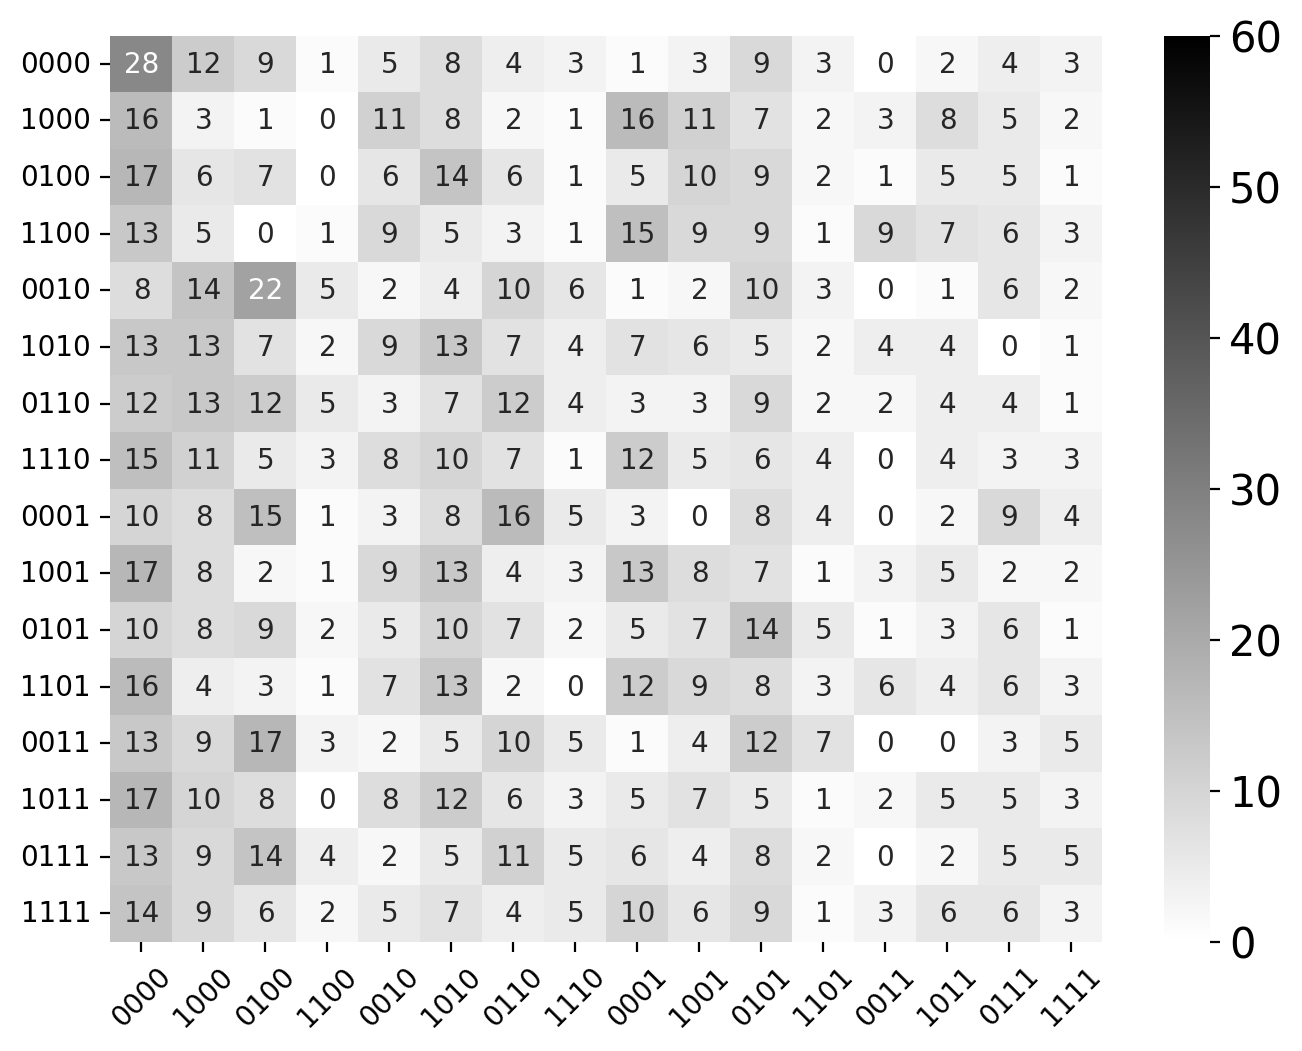

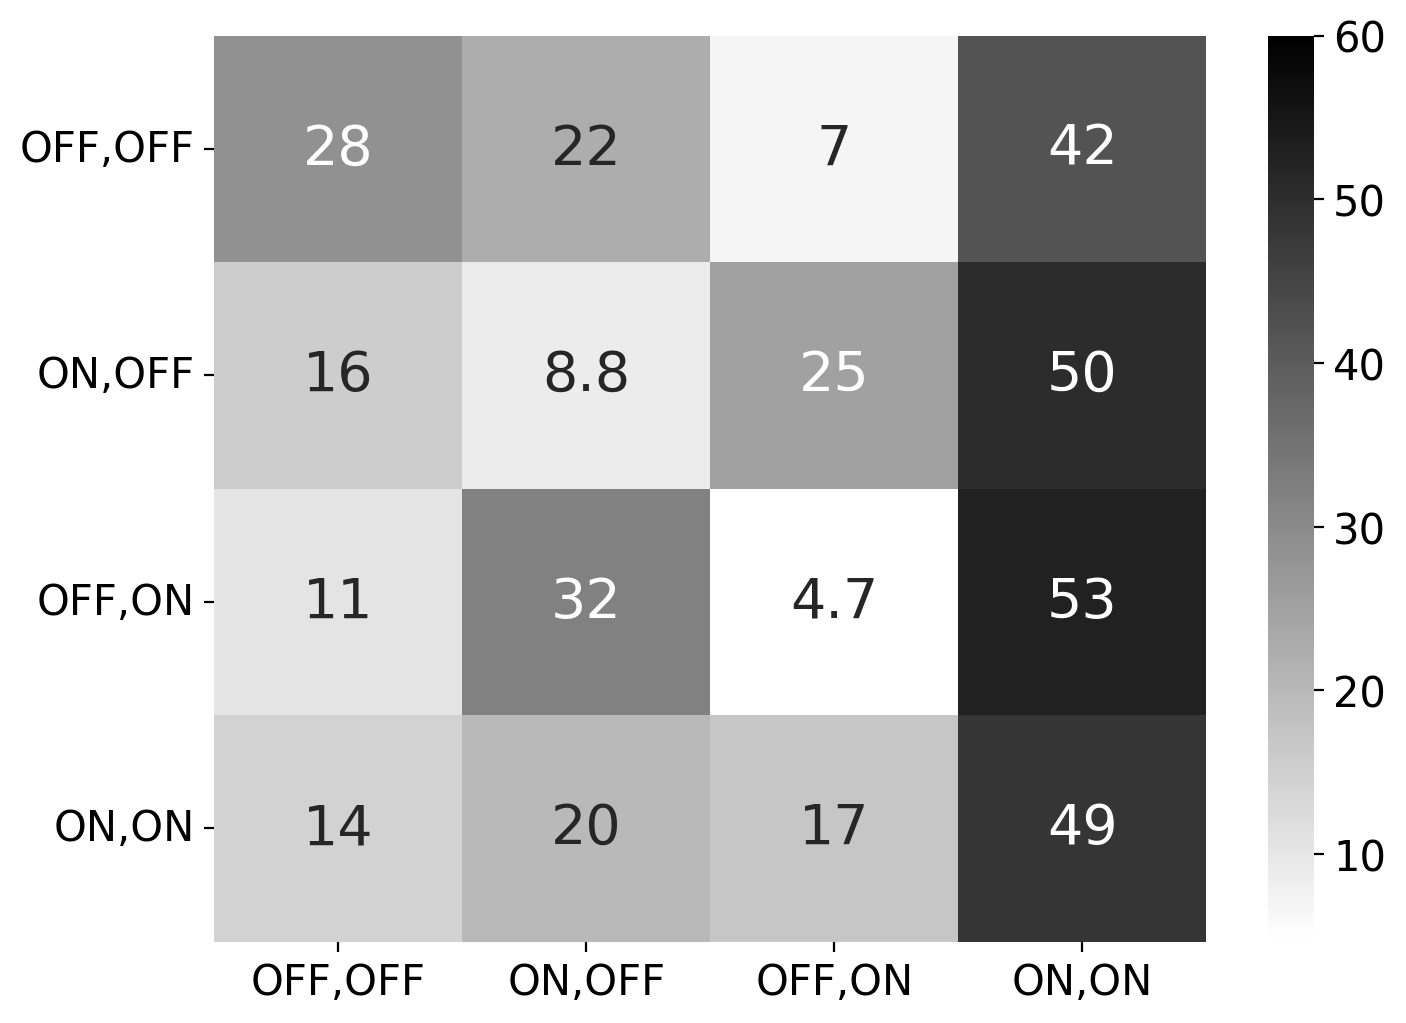

In [10]:
from temporal_emergence import CoarseGrainer, PhiCalculator, Helpers
import pyphi
import numpy as np
import matplotlib.pyplot as plt
import jupyter
import seaborn as sns
plt.rcParams.update({
    "text.usetex": False,
    "font.family": "sans-serif",
    "font.sans-serif": ["DejaVu Sans"]})
states_micro = ["0000", "1000", "0100", "1100", "0010", "1010", "0110", "1110", "0001", "1001", "0101", "1101", "0011", "1011", "0111", "1111"]
#[(b,a) for (a,b) in Helpers.get_nary_states(2,4)]
print(states_micro)
states_macro = ["OFF,OFF", "ON,OFF", "OFF,ON", "ON,ON"]


TPM_max_phi = np.loadtxt("results/macro_micros_fixed/micro_288_289_occs_200_bin_0.0178625_skip_2.csv")
plt.figure(figsize=(8, 6), dpi=200)

ax = sns.heatmap((TPM_max_phi*100).astype(int), annot=True, xticklabels=states_micro, yticklabels=states_micro, cmap="gray_r", vmax=60)
plt.xticks(rotation=45)
cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=15)

plt.savefig("figures/TPM_288_289_micro", transparent=False)
plt.show()
element_coarse_grainings = [[[0], [1,2,3]], [[0,1,2],[3]], [[0], [1,2], [3]], [[0], [1], [2], [3]]]
states, num_states_l = CoarseGrainer.get_state_maps(element_coarse_grainings)

plt.figure(figsize=(8, 6), dpi=200)
TPM_max_phi_coarse_grained = CoarseGrainer.coarse_grain_nonbinary_TPM(TPM_max_phi,states[0], num_states_l[0])
ax = sns.heatmap(TPM_max_phi_coarse_grained*100, annot=True, annot_kws={"fontsize":20}, xticklabels=states_macro, yticklabels=states_macro, cmap="gray_r", vmax=60)
plt.yticks(rotation=0, fontsize=15)
plt.xticks(rotation=0, fontsize=15)

cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=15)

plt.savefig("figures/TPM_288_289_macro", transparent=False)
plt.show()

### Figure 4

Computation of Φ for neuron pair 288-289 at state OFF,OFF, under the
$288,289_{max}$ parameterisation.

coarse-grained states:

 OFF,OFF ON,OFF        OFF,ON         ON,ON
{0: [0], 1: [1, 2, 3], 2: [4, 8, 12], 3: [5, 9, 13, 6, 10, 14, 7, 11, 15]}

number of coarse-grained states: [2, 2]

coarse-grained OR TPM:

[[0.285      0.225      0.07       0.42      ]
 [0.15666667 0.08833333 0.25166667 0.50333333]
 [0.10666667 0.32       0.04666667 0.52666667]
 [0.145      0.19833333 0.17166667 0.485     ]]


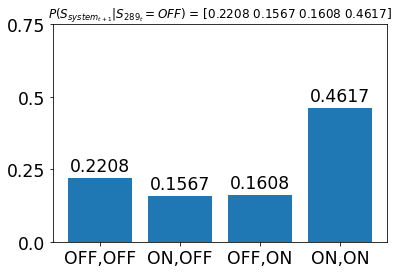

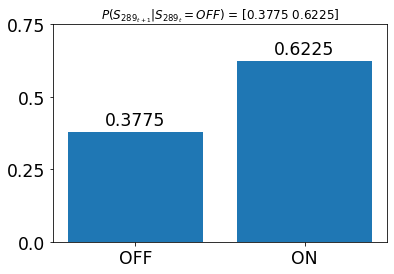

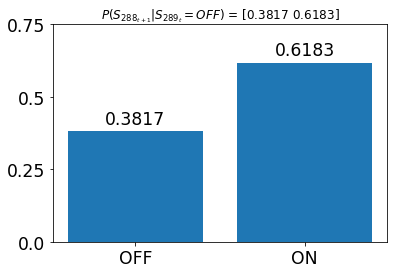

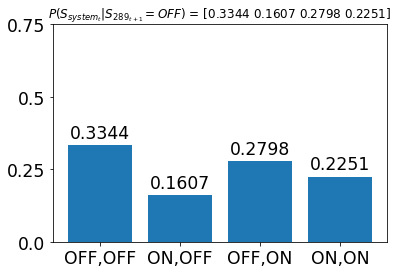

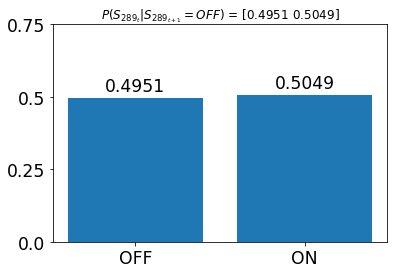

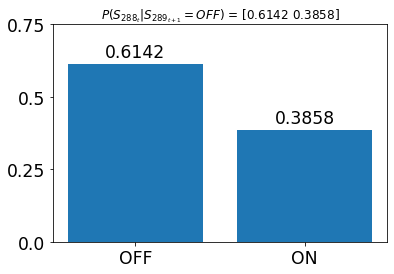

Network([[0.285      0.225      0.07       0.42      ]
 [0.15666667 0.08833333 0.25166667 0.50333333]
 [0.10666667 0.32       0.04666667 0.52666667]
 [0.145      0.19833333 0.17166667 0.485     ]], cm=[[1. 1.]
 [1. 1.]])
SSSSSSSSSSSSSSSSSS (0, 0) SSSSSSSSSSSSSSSSSS


Computing concepts:   0% 0/3 [00:00<?, ?it/s]

Computing concepts:  67% 2/3 [00:00<00:00, 17.30it/s]

Evaluating Φ cuts:   0% 0/2 [00:00<?, ?it/s]

Evaluating Φ cuts:  50% 1/2 [00:00<00:00,  7.41it/s]

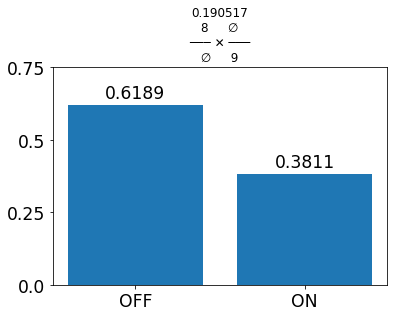

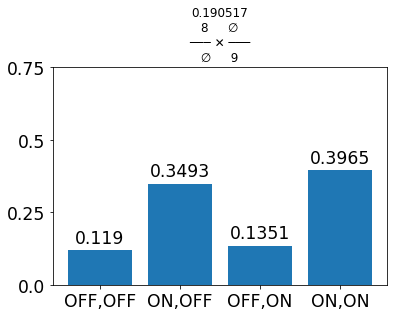

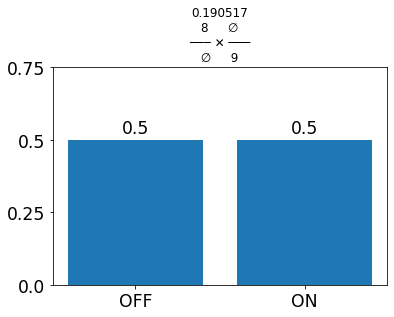

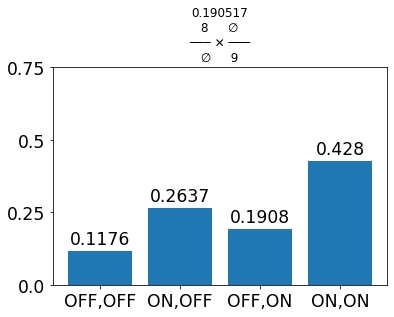

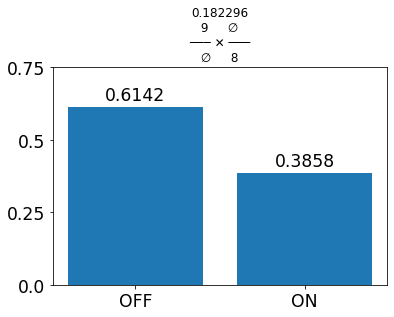

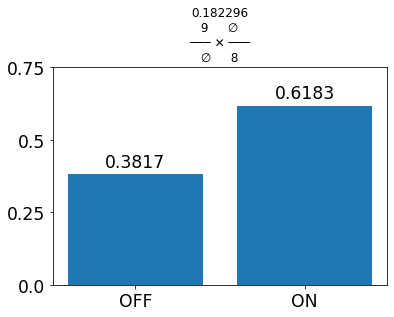

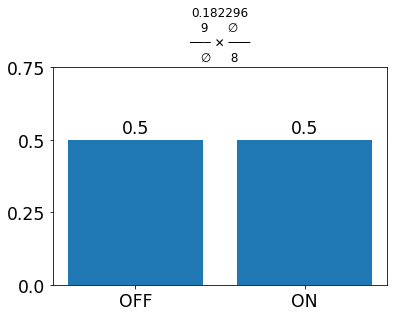

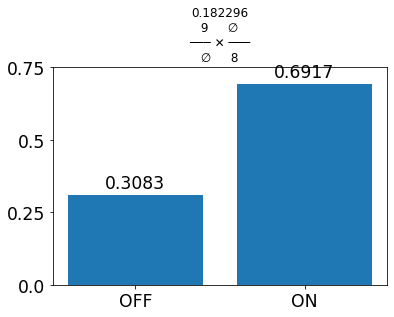

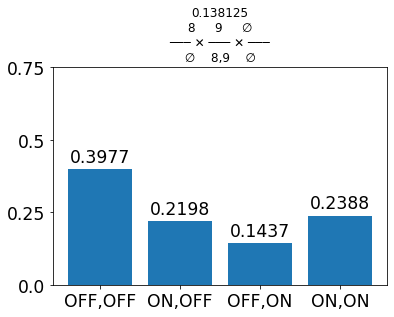

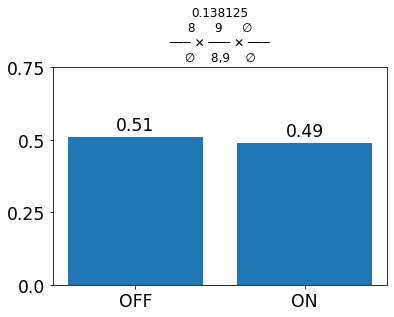

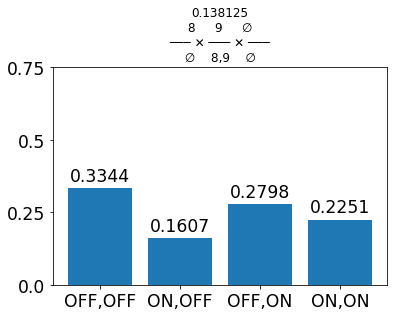

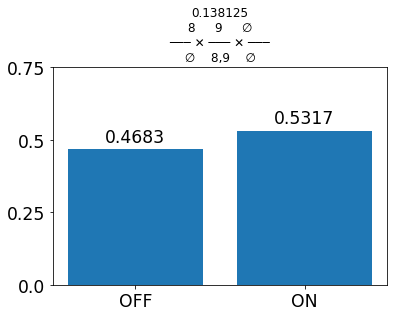

════════════════════════════════════════════════════════════
            Cause-effect structure (3 concepts)             
════════════════════════════════════════════════════════════
  ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━  
           Concept: Mechanism = [8], φ = 0.141667           
  ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━  
              MIC                         MIE               
  ┌──────────────────────────┐┌──────────────────────────┐  
  │  φ = 0.190517            ││  φ = 0.141667            │  
  │  Purview = [9]           ││  Purview = [8, 9]        │  
  │  MIP:                    ││  MIP:                    │  
  │     8     ∅              ││     8     ∅              │  
  │    ─── ✕ ───             ││    ─── ✕ ───             │  
  │     ∅     9              ││     ∅    8,9             │  
  │  Repertoire:             ││  Repertoire:             │  
  │    ┌────────────────┐    ││    ┌─────────────────┐   │  
  │    │ S    Pr(S)     

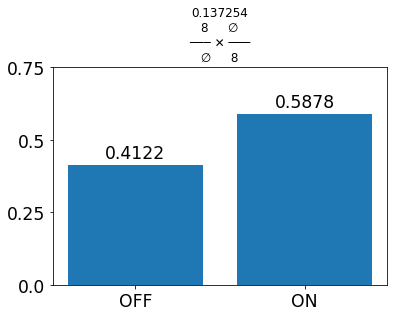

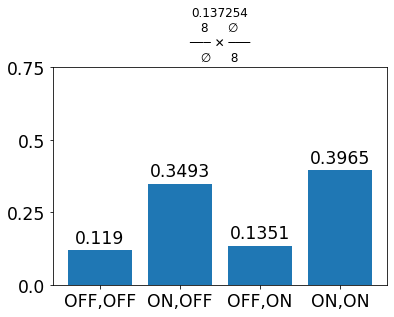

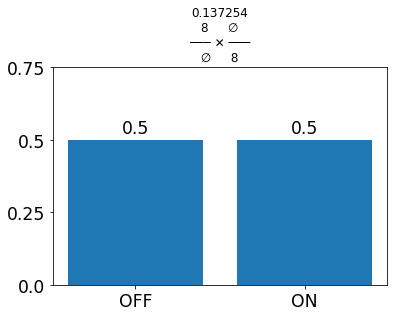

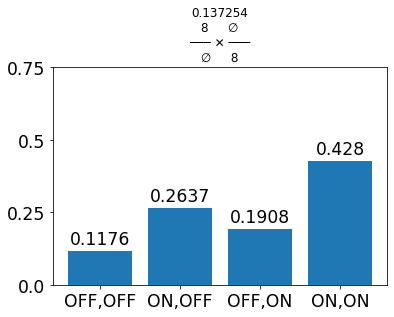

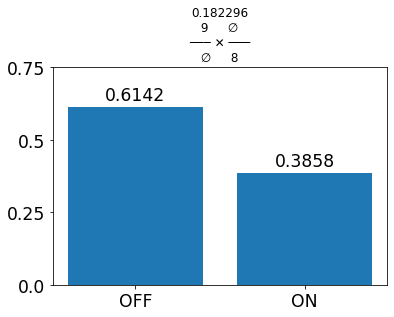

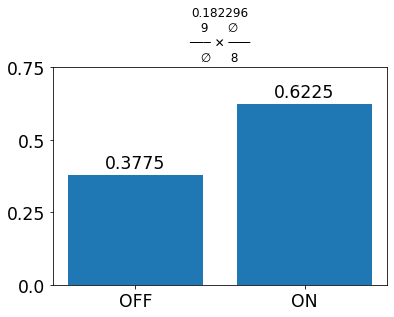

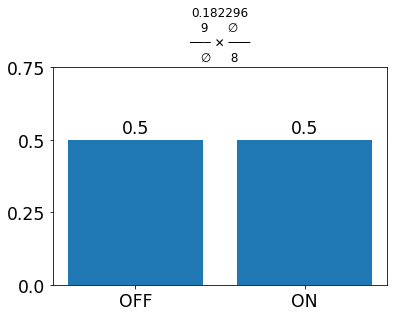

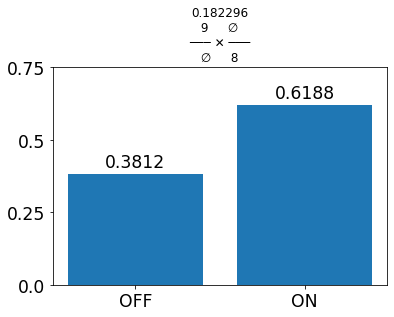

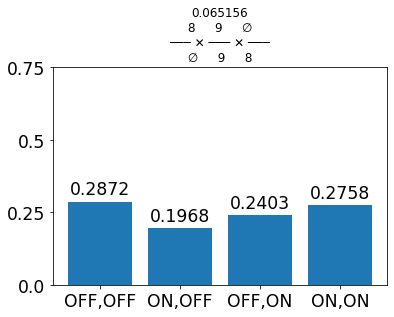

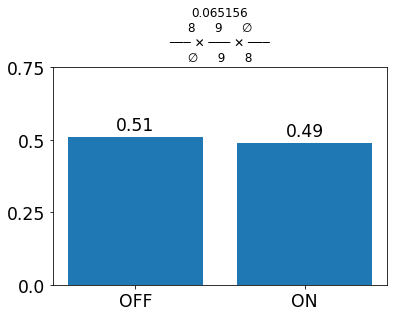

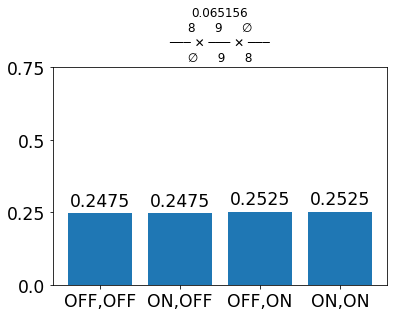

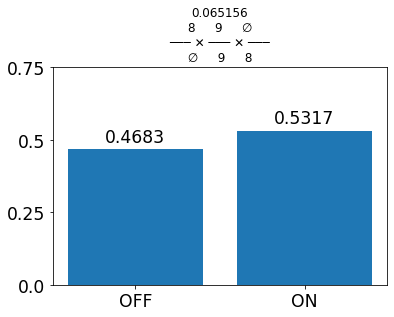

════════════════════════════════════════════════════════════
            Cause-effect structure (3 concepts)             
════════════════════════════════════════════════════════════
  ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━  
           Concept: Mechanism = [8], φ = 0.137254           
  ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━  
              MIC                         MIE               
  ┌──────────────────────────┐┌──────────────────────────┐  
  │  φ = 0.137254            ││  φ = 0.141667            │  
  │  Purview = [8]           ││  Purview = [8, 9]        │  
  │  MIP:                    ││  MIP:                    │  
  │     8     ∅              ││     8     ∅              │  
  │    ─── ✕ ───             ││    ─── ✕ ───             │  
  │     ∅     8              ││     ∅    8,9             │  
  │  Repertoire:             ││  Repertoire:             │  
  │    ┌────────────────┐    ││    ┌─────────────────┐   │  
  │    │ S    Pr(S)     

In [8]:
from temporal_emergence import CoarseGrainer, PhiCalculator, Helpers
from RepertoirePlotter import RepertoirePlotter
import numpy as np
import pyphi

TPM_max_phi = np.loadtxt("results/macro_micros_fixed/micro_288_289_occs_200_bin_0.0178625_skip_2.csv")
#                               OR               AND            3-STATE             IDENTITY
element_coarse_grainings = [[[0], [1,2,3]], [[0,1,2],[3]], [[0], [1,2], [3]], [[0], [1], [2], [3]]]
states, num_states_l = CoarseGrainer.get_state_maps(element_coarse_grainings)
# print OR coarse-graining
print("coarse-grained states:\n")
print(" OFF,OFF ON,OFF        OFF,ON         ON,ON")
print(states[0])                # len(states) == 16

print(f"\nnumber of coarse-grained states: {num_states_l[0]}")

TPM_max_phi_coarse_grained = CoarseGrainer.coarse_grain_nonbinary_TPM(TPM_max_phi, states[0], num_states_l[0])

print("\ncoarse-grained OR TPM:\n")
print(TPM_max_phi_coarse_grained)

## subfigures B and C ##

RepertoirePlotter.plot_from_tpm(TPM_max_phi_coarse_grained,
                                given_state=[0,1],
                                other_time_states=[[0],[1],[2],[3]],
                                xlabs=["OFF,OFF", "ON,OFF", "OFF,ON", "ON,ON"],
                                path="figures/fig4/",
                                fname=r'$P(S_{system_{t+1}} | S_{289_t} = OFF)$',
                                effect_purview=True)

RepertoirePlotter.plot_from_tpm(TPM_max_phi_coarse_grained,
                                given_state=[0,1],
                                other_time_states=[[0,1],[2,3]],
                                xlabs=["OFF", "ON"],
                                path="figures/fig4/",
                                fname=r"$P(S_{289_{t+1}} | S_{289_t} = OFF)$",
                                effect_purview=True)

RepertoirePlotter.plot_from_tpm(TPM_max_phi_coarse_grained,
                                given_state=[0,1],
                                other_time_states=[[0,2],[1,3]],
                                xlabs=["OFF", "ON"],
                                path="figures/fig4/",
                                fname=r"$P(S_{288_{t+1}} | S_{289_t} = OFF)$",
                                effect_purview=True)

RepertoirePlotter.plot_from_tpm(TPM_max_phi_coarse_grained,
                                given_state=[0,1],
                                other_time_states=[[0],[1],[2],[3]],
                                xlabs=["OFF,OFF", "ON,OFF", "OFF,ON", "ON,ON"],
                                path="figures/fig4/",
                                fname=r"$P(S_{system_t} | S_{289_{t+1}} = OFF)$",
                                effect_purview=False)

RepertoirePlotter.plot_from_tpm(TPM_max_phi_coarse_grained,
                                given_state=[0,1],
                                other_time_states=[[0,1],[2,3]],
                                xlabs=["OFF", "ON"],
                                path="figures/fig4/",
                                fname=r"$P(S_{289_t} | S_{289_{t+1}} = OFF)$",
                                effect_purview=False)

RepertoirePlotter.plot_from_tpm(TPM_max_phi_coarse_grained,
                                given_state=[0,1],
                                other_time_states=[[0,2],[1,3]],
                                xlabs=["OFF", "ON"],
                                path="figures/fig4/",
                                fname=r"$P(S_{288_t} | S_{289_{t+1}} = OFF)$",
                                effect_purview=False)

# subfigures D and E (minimally-irreducible partitions and AID)

# pyphi.config.VALIDATE_CONDITIONAL_INDEPENDENCE = False
# pyphi.config.MEASURE='EMD'

network = pyphi.Network(TPM_max_phi_coarse_grained,
                        num_states_per_node=num_states_l[0],
                        node_labels=('8', '9',))
print(network)
# states = Helpers.get_nary_states(2,2)
cur_states = [(0,0)]

for state in cur_states:
    print("SSSSSSSSSSSSSSSSSS " + str(state) + " SSSSSSSSSSSSSSSSSS")
    subsystem = pyphi.Subsystem(network, state)
    sia = pyphi.compute.sia(subsystem)

    for concept,label in zip(sia.ces, sia.ces.labeled_mechanisms):
        path="figures/fig4/" + str(label).replace("'", "") + "/"
        # plot "normal" repertoire
        RepertoirePlotter.plot_core(concept, path, MIP=False)
        # plot MIP repertoire
        RepertoirePlotter.plot_core(concept, path, MIP=True)

    print(sia.ces)
    print(sia.cut)

    # cuts (integration)
    labels = (f'{str(i)} ({str(sia.cut).replace("━━/ /━━➤", "->")})'
              for i in sia.partitioned_ces.labeled_mechanisms)
    for concept,label in zip(sia.partitioned_ces, labels):
        path="figures/fig4/" + str(label).replace("'", "") + "/"
        RepertoirePlotter.plot_core(concept, path, MIP=False)
        RepertoirePlotter.plot_core(concept, path, MIP=True)

    print(sia.partitioned_ces)

    print('φ = ' + str(sia.phi))

In [69]:
## NUMBER OF BITS PER STATE IN EACH COARSE GRAINING
num_bits_per_state_neuron = [2,2,3,4] # OR, AND, 3-STATE, IDENTITY
coarse_graining_labels_neuron = ["OR", "AND", "3-STATE", "I"]
num_bits_per_state = np.array([num_bits_per_state_neuron[i] * num_bits_per_state_neuron[j] for i in range(4) for j in range(4)])
inds = num_bits_per_state.argsort()

### Same idea as for the plot above, but coarse grainings with the same number of bits are grouped

In [70]:
# group coarse grainings by number of bits of the coarse graining state
def grouped_by_bits(dataset):
    grouped_results = []
    for bits in list(set(num_bits_per_state)):
        grouped_result = []
        for i in range(len(num_bits_per_state)):
            if num_bits_per_state[i] == bits:
                grouped_result.extend(dataset[:,i])
        grouped_results.append(grouped_result)
    return grouped_results

### Plot the Phi value as number of possible states in system increases

In [ ]:
num_bits_per_state[num_bits_per_state.argsort()]

In [ ]:
stacked_macros_micros = np.stack(all_16_macro_micros_connected[:,1])
#stacked_macros_micros = np.stack(all_16_macro_micros_disconnected[:,1])
print(stacked_macros_micros.shape)
grouped_across_params_and_pairs = np.empty((stacked_macros_micros.shape[0], \
    stacked_macros_micros.shape[1]*stacked_macros_micros.shape[2],stacked_macros_micros.shape[3]))

for i in range(stacked_macros_micros.shape[0]):
    for j in range(stacked_macros_micros.shape[3]):
        grouped_across_params_and_pairs[i,:,j] = stacked_macros_micros[i,:,:,j].flatten()

grouped_across_params_and_pairs_neurons = np.empty((grouped_across_params_and_pairs.shape[0] \
    * grouped_across_params_and_pairs.shape[1], grouped_across_params_and_pairs.shape[2]))

for i in range(grouped_across_params_and_pairs.shape[2]):
    grouped_across_params_and_pairs_neurons[:,i] = grouped_across_params_and_pairs[:,:,i].flatten()

grouped_across_params_and_pairs_negs_replaced = grouped_across_params_and_pairs_neurons
grouped_across_params_and_pairs_negs_replaced[grouped_across_params_and_pairs_negs_replaced < 0] = 0

grouped_across_params_and_pairs_sorted = grouped_across_params_and_pairs_negs_replaced[:,inds]

fig, ax = plt.subplots(figsize=(8,6), dpi=200)
ax = sns.boxplot(ax=ax,data=grouped_across_params_and_pairs_sorted, orient='v', color=".8", width=0.4, showfliers=False)
for i in range(16):
    if i < 4:
        ax.artists[i].set_facecolor('mediumseagreen')
    if i >= 4 and i < 8:
        ax.artists[i].set_facecolor('deepskyblue')
    if i >= 8 and i < 12:
        ax.artists[i].set_facecolor('mediumorchid')
    if i == 12:
        ax.artists[i].set_facecolor('tomato')
    if i >= 13 and i < 15:
        ax.artists[i].set_facecolor('orange')
    if i == 15:
        ax.artists[i].set_facecolor('gold')

ax = sns.stripplot(ax=ax,data=grouped_across_params_and_pairs_sorted, orient='v',color=".4", jitter=0.02)
ax.set_xticklabels([], rotation=45, ha='right', fontsize=13)
ax.set_yticklabels(np.around(ax.get_yticks(), decimals=2), fontsize=15)
plt.show()

In [ ]:
grouped_allneurons = grouped_by_bits(grouped_across_params_and_pairs_neurons)
fig, ax = plt.subplots(figsize=(8,6), dpi=100)
ax = sns.stripplot(ax=ax,data=grouped_allneurons, orient='v',color=".4", jitter=0.02)
ax = sns.boxplot(ax=ax,data=grouped_allneurons, orient='v', color=".8", width=0.4, showfliers=False)
for i in range(6):
    if i == 0:
        ax.artists[i].set_facecolor('mediumseagreen')
    if i == 1:
        ax.artists[i].set_facecolor('deepskyblue')
    if i == 2:
        ax.artists[i].set_facecolor('mediumorchid')
    if i == 3:
        ax.artists[i].set_facecolor('tomato')
    if i == 4:
        ax.artists[i].set_facecolor('orange')
    elif i == 5:
        ax.artists[i].set_facecolor('gold')

ax.set_xticklabels([], ha='center', fontsize=15)
ax.set_yticklabels([], fontsize=15)
plt.show()

In [ ]:
grouped_across_params = np.stack(all_16_macro_micros_connected[:,1]).reshape(732,9*5,16)
#grouped_across_params = np.stack(all_16_macro_micros_disconnected[:,1]).reshape(736,9*5,16)

max_across_pairs = np.nanmax(grouped_across_params, axis=1)
max_across_pairs_sorted = max_across_pairs[:,inds]
fig, ax = plt.subplots(figsize=(8,6), dpi=200)
ax = sns.boxplot(ax=ax,data=max_across_pairs_sorted, orient='v', color=".8", width=0.4, showfliers=False)
for i in range(16):
    if i < 4:
        ax.artists[i].set_facecolor('mediumseagreen')
    if i >= 4 and i < 8:
        ax.artists[i].set_facecolor('deepskyblue')
    if i >= 8 and i < 12:
        ax.artists[i].set_facecolor('mediumorchid')
    if i == 12:
        ax.artists[i].set_facecolor('tomato')
    if i >= 13 and i < 15:
        ax.artists[i].set_facecolor('orange')
    if i == 15:
        ax.artists[i].set_facecolor('gold')

ax = sns.stripplot(ax=ax,data=max_across_pairs_sorted, orient='v',color=".4", jitter=0.02)
ax.set_xticklabels(coarse_graining_labels[inds], rotation=45, ha='right', fontsize=13)
ax.set_yticklabels(np.around(ax.get_yticks(), decimals=2), fontsize=15)
plt.show()

In [ ]:
grouped_allneurons_max = grouped_by_bits(max_across_pairs)
fig, ax = plt.subplots(figsize=(8,6), dpi=100)
ax = sns.boxplot(ax=ax,data=grouped_allneurons_max, orient='v', color=".8", width=0.4, showfliers=False)
for i in range(6):
    if i == 0:
        ax.artists[i].set_facecolor('mediumseagreen')
    if i == 1:
        ax.artists[i].set_facecolor('deepskyblue')
    if i == 2:
        ax.artists[i].set_facecolor('mediumorchid')
    if i == 3:
        ax.artists[i].set_facecolor('tomato')
    if i == 4:
        ax.artists[i].set_facecolor('orange')
    elif i == 5:
        ax.artists[i].set_facecolor('gold')

ax = sns.stripplot(ax=ax,data=grouped_allneurons_max, orient='v',color=".4", jitter=0.02)

ax.set_xticklabels(list(set(num_bits_per_state)), ha='center', fontsize=15)
ax.set_yticklabels([], fontsize=15)
plt.show()

### Now group by the binsize

In [ ]:
stacked_macros_micros = np.stack(all_16_macro_micros_connected[:,1])
stacked_macros_micros.shape

# group across tau, coarse-graining (2nd, 3rd dimensions 0 indexed)
grouped_by_binsize = np.empty((stacked_macros_micros.shape[0], stacked_macros_micros.shape[1], \
    stacked_macros_micros.shape[2] * stacked_macros_micros.shape[3]))
for i in range(stacked_macros_micros.shape[0]):
    for j in range(stacked_macros_micros.shape[1]):
        grouped_by_binsize[i,j,:] = (stacked_macros_micros[i,j]).flatten()
print(grouped_by_binsize.shape)

# join across neurons, giving dimensions (732*80, 9)
grouped_by_binsize_neurons = np.empty((grouped_by_binsize.shape[0] * grouped_by_binsize.shape[2], \
    grouped_by_binsize.shape[1]))
for i in range(grouped_by_binsize.shape[1]):
    grouped_by_binsize_neurons[:,i] = (grouped_by_binsize[:,i,:]).flatten()
print(grouped_by_binsize_neurons.shape)

fig, ax = plt.subplots(figsize=(8,6), dpi=100)
ax = sns.boxplot(ax=ax,data=grouped_by_binsize_neurons, orient='v', color=".8", width=0.4, showfliers=False)
ax = sns.stripplot(ax=ax,data=grouped_by_binsize_neurons, orient='v',color=".4", jitter=0.02)

### Max Phi of each neuron pair for a given binsize

In [ ]:
stacked_macros_micros = np.stack(all_16_macro_micros_connected[:,1])
stacked_macros_micros.shape

# group across tau, coarse-graining (2nd, 3rd dimensions 0 indexed)
grouped_by_binsize = np.empty((stacked_macros_micros.shape[0], stacked_macros_micros.shape[1], \
    stacked_macros_micros.shape[2] * stacked_macros_micros.shape[3]))
for i in range(stacked_macros_micros.shape[0]):
    for j in range(stacked_macros_micros.shape[1]):
        grouped_by_binsize[i,j,:] = (stacked_macros_micros[i,j]).flatten()
print(grouped_by_binsize.shape)
grouped_by_binsize_max = np.nanmax(grouped_by_binsize, 2)
print(grouped_by_binsize_max.shape)

fig, ax = plt.subplots(figsize=(8,6), dpi=100)
ax = sns.boxplot(ax=ax,data=grouped_by_binsize_max, orient='v', color=".8", width=0.4, showfliers=False)
ax = sns.stripplot(ax=ax,data=grouped_by_binsize_max, orient='v',color=".4", jitter=0.02)


### Number of successful TPM estimations as sample requirement increases

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

minimal_connections = np.load("results/min_occurrences.npy", allow_pickle=True)
minimal_connections = [conn[2] for conn in minimal_connections]

max_binsize = 0.02  # 20 ms bins
min_binsize = 0.0029 # skip 1ms bins  -   never work and are very slow to compute
binsize = np.linspace(min_binsize, max_binsize, 9)
minimal_connections = np.transpose(minimal_connections)
#plt.figure(figsize = (8,6), dpi=100)
fig, ax = plt.subplots(3,3, figsize=(8,6), dpi=100)
#fig.suptitle('Minimum number of state samples for TPM \n bidirectionally connected neurons')
fig.tight_layout()
plt.grid(False)
fig.add_subplot(111, frameon=False)
# hide tick and tick label of the big axes
plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
plt.grid(False)
plt.ylabel("Frequency")
plt.xlabel("Minimum number of state samples")

for i in range(3):
    for j in range(3):
        #plt.figure()
        ax[i,j].hist(minimal_connections[i*3 + j], bins = 10)
        ax[i,j].set_yscale('log')
        ax[i,j].set_xlim([0, 1000])
        ax[i,j].set_ylim([1, 10**3])
        ax[i,j].set_title("binsize: " + '%.4f' % (binsize[i*3 + j]))
plt.subplots_adjust(top=0.8)

for ax in fig.get_axes():
    ax.label_outer()

plt.figure(figsize = (8,6), dpi=100)
for i in range(minimal_connections.shape[0]):
    h,x = np.histogram(minimal_connections[i], bins=25)
    bin_centers = 0.5*(x[1:]+x[:-1])
    print(bin_centers[0])
    plt.plot(bin_centers,h, label='%.3f' % (binsize[i]))
    plt.yscale('log')
    plt.xlim([0,1000])
    plt.ylabel("Frequency")
    plt.xlabel("Minimum number of state samples")
    plt.title('Minimum number of state samples for TPM \n bidirectionally connected neurons')
    plt.legend()
minimal_connections.shape

### Phi difference as TPM samples increase

In [ ]:
# 143_168 results for different number of reps
folder = "results/n_143_168_macrowins"
import os
its = []
for filename in os.listdir(folder):
    it = np.load(folder + "/" + filename)
    its.append(it)
results = [[] for i in range(5)]
for it in its:
    for res in it:
        index = int(res[1] // 200) - 1
        results[index].append(res[0])

import pandas as pd
plt.figure(figsize = (8,6), dpi=100)
df = pd.DataFrame(np.transpose(np.array(results)))
ax = sns.boxplot(data=df, orient='v', color=".8", width=0.4)
ax = sns.stripplot(data=df)
ax.set_xticklabels(["200", "400", "600", "800", "1000"])
plt.title("Difference between Macro and Micro Phi for 143-168\nAt different sampling requirements")
plt.ylabel("Macro Phi - Micro Phi across parameters")
plt.xlabel("Samples/state to construct TPM")
plt.axhline(y=0, color='gray', linestyle='-')